In [1]:
"""
band-selective vector search POC

- learns a linear spectral probe mapping embeddings -> band-masked spectral profiles
- derives class-specific band weights from predicted spectra
- compares baseline cosine on embeddings vs. band-selective cosine on predicted spectra

note: single-line comments keep lowercase per user preference.
"""

from __future__ import annotations

# --- imports -----------------------------------------------------------------
import os
import json
import joblib
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Set
from tqdm import tqdm
from scipy.io import wavfile
import scipy.signal as sg
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


# --- metrics -----------------------------------------------------------------

def cosine(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """cosine similarity rows(a) vs rows(b). returns (a_rows, b_rows)."""
    # ensure 2d
    if a.ndim == 1:
        a = a[None, :]
    if b.ndim == 1:
        b = b[None, :]
    na = np.linalg.norm(a, axis=1) + eps
    nb = np.linalg.norm(b, axis=1) + eps
    return (a @ b.T) / (na[:, None] * nb[None, :] + eps)


def precision_at_k(rel_idx_set: Set[int], ranking: np.ndarray, k: int = 10) -> float:
    # compute precision@k for a single query
    topk = ranking[:k]
    return float(sum(int(i in rel_idx_set) for i in topk) / max(1, k))


def average_precision(rel_idx_set: Set[int], ranking: np.ndarray) -> float:
    # compute average precision for a single query
    num_rel = 0
    s = 0.0
    for r, i in enumerate(ranking, 1):
        if i in rel_idx_set:
            num_rel += 1
            s += num_rel / r
    return float(s / max(1, len(rel_idx_set)))


def evaluate_method(sim_rows: np.ndarray, relevant_sets: List[Set[int]], ks: Tuple[int, ...] = (10,)) -> Dict[str, float]:
    # evaluate a retrieval similarity matrix against relevance sets
    out = {f"P@{k}": [] for k in ks}
    mAP = []
    for q, sims in enumerate(sim_rows):
        ranking = np.argsort(-sims)
        rel = relevant_sets[q]
        for k in ks:
            out[f"P@{k}"].append(precision_at_k(rel, ranking, k))
        mAP.append(average_precision(rel, ranking))
    return {k: float(np.mean(v)) for k, v in out.items()} | {"mAP": float(np.mean(mAP))}


# --- spectral probe -----------------------------------------------------------

class SpectralProbe:
    """linear probe: embeddings (n,d) -> band-masked spectral profiles (n,K)."""

    def __init__(self, alpha: float = 1e-2):
        self.alpha = alpha
        self.scaler = StandardScaler(with_mean=True, with_std=True)
        self.reg: Ridge | None = None
        self.W: np.ndarray | None = None  # (d, K)
        self.intercept_: np.ndarray | None = None  # (K,)

    def fit(self, E: np.ndarray, Y: np.ndarray) -> "SpectralProbe":
        # standardize embeddings for stable coefficients
        X = self.scaler.fit_transform(E)
        self.reg = Ridge(alpha=self.alpha, fit_intercept=True)
        self.reg.fit(X, Y)  # multi-output
        W_std = self.reg.coef_.T  # (d_std, K)
        self.W = W_std / (self.scaler.scale_[:, None] + 1e-12)  # map back to original space
        self.intercept_ = self.reg.intercept_.copy()
        return self

    def predict(self, E: np.ndarray) -> np.ndarray:
        # predict nonnegative spectral profiles from embeddings
        assert self.W is not None and self.intercept_ is not None, "probe not fitted"
        Y_hat = E @ self.W + self.intercept_[None, :]
        return np.maximum(Y_hat, 0.0)


# --- band weighting -----------------------------------------------------------

def learn_band_weights(
    Y_hat_train: np.ndarray,
    Y_multilabel_train: np.ndarray,
    smooth_sigma_bins: int | float = 2,
) -> np.ndarray:
    """
    learn class-specific band weights from predicted spectra.

    Y_hat_train: (n_train, K) predicted spectra from probe
    Y_multilabel_train: (n_train, C) binary matrix (1 if class present)

    returns: (C, K) nonnegative weights per class, each normalized to [0, 1]
    """
    C = Y_multilabel_train.shape[1]
    K = Y_hat_train.shape[1]
    Wc = np.zeros((C, K), dtype=float)

    for c in range(C):
        pos = Y_multilabel_train[:, c] == 1
        neg = ~pos
        if pos.sum() == 0 or neg.sum() == 0:
            continue
        mu_pos = Y_hat_train[pos].mean(axis=0)
        mu_neg = Y_hat_train[neg].mean(axis=0)
        w = np.clip(mu_pos - mu_neg, 0.0, None)  # emphasize class-specific excess energy

        # optional gaussian smoothing (in frequency-bin domain)
        if smooth_sigma_bins and smooth_sigma_bins > 0:
            r = int(4 * smooth_sigma_bins + 1)
            x = np.arange(-r, r + 1)
            g = np.exp(-0.5 * (x / (smooth_sigma_bins + 1e-12)) ** 2)
            g /= g.sum()
            w = np.convolve(w, g, mode="same")

        if w.max() > 0:
            w = w / w.max()
        Wc[c] = w

    return Wc


def band_weighted_similarity(Yq: np.ndarray, Y_db: np.ndarray, w: np.ndarray) -> np.ndarray:
    # cosine similarity on spectra, weighted by per-class band mask w (length K)
    Yw = Y_db * w[None, :]
    q = Yq * w
    denom = (np.linalg.norm(Yw, axis=1) * (np.linalg.norm(q) + 1e-12) + 1e-12)
    return (Yw @ q) / denom


# --- targets (band-masked spectral profiles) ---------------------------------

def band_masked_profile(
    x: np.ndarray,
    sr: int,
    f_min: float,
    f_max: float,
    n_fft: int = 1024,
    hop: int = 256,
    n_bins: int = 128,
    fmin: float = 0.0,
    fmax: float | None = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    compute a band-masked frequency profile for a target event.
    - masks spectrogram to [f_min, f_max] across all times (use time-cropped clips upstream)
    - averages over time and bins into n_bins across [fmin, fmax]

    returns: (profile[K], f_centers[K])
    """
    if fmax is None:
        fmax = sr / 2

    # compute spectrogram (magnitude, power-scaled)
    f, t, S = sg.spectrogram(
        x, fs=sr, nperseg=n_fft, noverlap=n_fft - hop, scaling="spectrum", mode="magnitude"
    )

    # frequency mask
    f_mask = (f >= f_min) & (f <= f_max)
    S_masked = np.zeros_like(S)
    S_masked[f_mask] = S[f_mask]

    # average over time
    S_band = S_masked.mean(axis=1)  # (n_freq,)

    # bin to fixed grid
    edges = np.linspace(fmin, fmax, n_bins + 1)
    y = np.zeros(n_bins, dtype=float)
    for i in range(n_bins):
        in_bin = (f >= edges[i]) & (f < edges[i + 1])
        if np.any(in_bin):
            y[i] = S_band[in_bin].mean()
    y = np.log1p(y)  # mild compression

    f_centers = 0.5 * (edges[:-1] + edges[1:])
    return y, f_centers


# --- helpers for dataset-specific bits --------------------------------------

def get_freq_range(filename, annotations_df):
    # parse parts
    species_songtype, rest = filename.split('/')
    species_id = int(species_songtype.split('species')[1].split('_')[0])
    songtype_id = int(species_songtype.split('songtype')[1])
    
    recording_id, t_min, t_max = rest.replace('.wav','').split('_')
    t_min = float(t_min)
    t_max = float(t_max)

    # find the matching row
    row = annotations_df[
        (annotations_df['species_id'] == species_id) &
        (annotations_df['songtype_id'] == songtype_id) &
        (annotations_df['recording_id'] == recording_id) &
        (annotations_df['t_min'].round(2) == round(t_min, 2)) &
        (annotations_df['t_max'].round(2) == round(t_max, 2))
    ]

    if not row.empty:
        return row.iloc[0]['f_min'], row.iloc[0]['f_max']
    else:
        return None


# --- end-to-end POC (class-wise evaluation) ---------------------------------

def normalize_profiles(Y):
    Y = np.array(Y, dtype=np.float32)
    sums = Y.sum(axis=1, keepdims=True)
    sums[sums == 0] = 1.0
    return Y / sums

def poc_band_selective_search(
    E: np.ndarray,
    Y_multilabel: np.ndarray,
    band_masked_spectral_profiles: np.ndarray,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    db_idx: np.ndarray,
    ks: Tuple[int, ...] = (1, 5, 10),
):
    # normalize targets before fitting
    band_masked_spectral_profiles = normalize_profiles(band_masked_spectral_profiles)

    # fit spectral probe on train
    probe = SpectralProbe(alpha=1e-2).fit(
        E[train_idx], band_masked_spectral_profiles[train_idx]
    )

    # predict spectra for splits
    Yhat_train = normalize_profiles(probe.predict(E[train_idx]))
    Yhat_val   = normalize_profiles(probe.predict(E[val_idx]))
    Yhat_db    = normalize_profiles(probe.predict(E[db_idx]))

    # learn class-specific band weights on train
    Wc = learn_band_weights(Yhat_train, Y_multilabel[train_idx], smooth_sigma_bins=2)

    # baseline cosine on embeddings
    E_val = E[val_idx]
    E_db = E[db_idx]
    sims_base_all = cosine(E_val, E_db)

    # class-wise evaluation loop (unchanged)
    results: Dict[int, Dict[str, Dict[str, float]]] = {}
    class_ids = np.arange(Y_multilabel.shape[1])

    for c in class_ids:
        q_mask = Y_multilabel[val_idx, c] == 1
        if not np.any(q_mask):
            continue
        q_rows = np.where(q_mask)[0]
        db_mask = Y_multilabel[db_idx, c] == 1
        rel_idx = set(np.where(db_mask)[0])
        rel_sets = [rel_idx for _ in q_rows]

        w_c = Wc[c]
        if w_c.max() == 0:
            continue

        sims_band = np.vstack([
            band_weighted_similarity(Yhat_val[q], Yhat_db, w_c) for q in q_rows
        ])
        sims_base = sims_base_all[q_rows]

        res_base = evaluate_method(sims_base, rel_sets, ks=ks)
        res_band = evaluate_method(sims_band, rel_sets, ks=ks)
        results[int(c)] = {"baseline": res_base, "band_selective": res_band}

    return results, Wc, probe, Yhat_val



# --- dataset loading sketch (customize paths) --------------------------------
if __name__ == "__main__":
    # config
    n_bins = 128
    fmin, fmax = 50.0, 16000.0

    # user paths (adjust)
    embeddings_dir = "../../artifacts/embeddings/20250811-075752/perch_bird/tp/"
    clips_dir = "../../data/audio/clips/tp/"
    annotations_csv = "../../data/annotations/train_tp.csv"

    # load metadata
    print("loading metadata …")
    anno = pd.read_csv(annotations_csv)
    embeddings_list = joblib.load(os.path.join(embeddings_dir, "embeddings.joblib"))
    labels_raw = json.load(open(os.path.join(embeddings_dir, "labels.json"), "r"))
    filenames = json.load(open(os.path.join(embeddings_dir, "filenames.json"), "r"))

    # label mapping (single-class per clip)
    class_to_int = {name: idx for idx, name in enumerate(sorted(set(labels_raw)))}
    classes = np.array([class_to_int[name] for name in labels_raw], dtype=int)

    # stack embeddings
    E = np.vstack(embeddings_list).astype(np.float32)

    # build band-masked spectral profiles from raw, time-cropped clips
    print("building band-masked spectral profiles …")
    profiles = []
    missing = 0

    for i, file in enumerate(tqdm(filenames, desc="profiles")):
        sr, audio = wavfile.read(os.path.join(clips_dir, file))

        # downmix to mono if stereo
        if audio.ndim > 1:
            audio = audio.mean(axis=1)

        # convert to float [-1, 1] if integer PCM
        if np.issubdtype(audio.dtype, np.integer):
            maxv = max(1.0, float(np.iinfo(audio.dtype).max))
            audio = audio.astype(np.float32) / maxv
        else:
            audio = audio.astype(np.float32)

        fr = get_freq_range(file, anno)
        if fr is None:
            missing += 1
            y = np.zeros(n_bins, dtype=float)
        else:
            f_min, f_max = fr
            # clip to global analysis band
            f_min = float(np.clip(f_min, fmin, fmax))
            f_max = float(np.clip(f_max, fmin, fmax))
            if f_min >= f_max:
                missing += 1
                y = np.zeros(n_bins, dtype=float)
            else:
                y, _ = band_masked_profile(
                    audio, sr, f_min, f_max,
                    n_fft=1024, hop=256, n_bins=n_bins, fmin=fmin, fmax=fmax
                )

        profiles.append(y)

    print(f"band ranges missing/mismatched for {missing} / {len(filenames)} clips")
    band_masked_spectral_profiles = np.vstack(profiles).astype(np.float32)


    # one-hot for classes
    class_ids = np.unique(classes)
    cid2idx = {cid: i for i, cid in enumerate(class_ids)}
    C = len(class_ids)
    Y_multilabel = np.zeros((len(E), C), dtype=int)
    for i, cid in enumerate(classes):
        Y_multilabel[i, cid2idx[cid]] = 1

    # splits
    rng = np.random.default_rng(0)
    idx = np.arange(len(E))
    rng.shuffle(idx)
    n_train = int(0.6 * len(idx))
    n_val = int(0.2 * len(idx))
    train_idx = idx[:n_train]
    val_idx = idx[n_train : n_train + n_val]
    db_idx = idx[n_train + n_val :]

    # run POC
    print("running POC …")
    results, class_specific_band_weights, probe, Yhat_val = poc_band_selective_search(
        E, Y_multilabel, band_masked_spectral_profiles, train_idx, val_idx, db_idx, ks=(1, 5, 10)
    )

#     # pretty print results
#     import pprint as _pp

#     _pp.pprint(results)


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


loading metadata …
building band-masked spectral profiles …


profiles: 100%|██████████| 1216/1216 [00:08<00:00, 144.81it/s]


band ranges missing/mismatched for 4 / 1216 clips
running POC …


In [2]:
results


{0: {'baseline': {'P@1': 0.9285714285714286,
   'P@5': 0.6,
   'P@10': 0.39285714285714285,
   'mAP': 0.48330095992696653},
  'band_selective': {'P@1': 0.42857142857142855,
   'P@5': 0.48571428571428577,
   'P@10': 0.35000000000000003,
   'mAP': 0.4064125918478373}},
 1: {'baseline': {'P@1': 1.0,
   'P@5': 1.0,
   'P@10': 0.9285714285714286,
   'mAP': 0.9536602689506501},
  'band_selective': {'P@1': 0.2857142857142857,
   'P@5': 0.17142857142857146,
   'P@10': 0.14285714285714285,
   'mAP': 0.1201311386509346}},
 2: {'baseline': {'P@1': 0.8181818181818182,
   'P@5': 0.8181818181818182,
   'P@10': 0.6545454545454545,
   'mAP': 0.7804369421794255},
  'band_selective': {'P@1': 0.09090909090909091,
   'P@5': 0.07272727272727274,
   'P@10': 0.10909090909090911,
   'mAP': 0.11783615656215195}},
 3: {'baseline': {'P@1': 0.6363636363636364,
   'P@5': 0.34545454545454546,
   'P@10': 0.2909090909090909,
   'mAP': 0.29926157396232383},
  'band_selective': {'P@1': 0.09090909090909091,
   'P@5': 0.

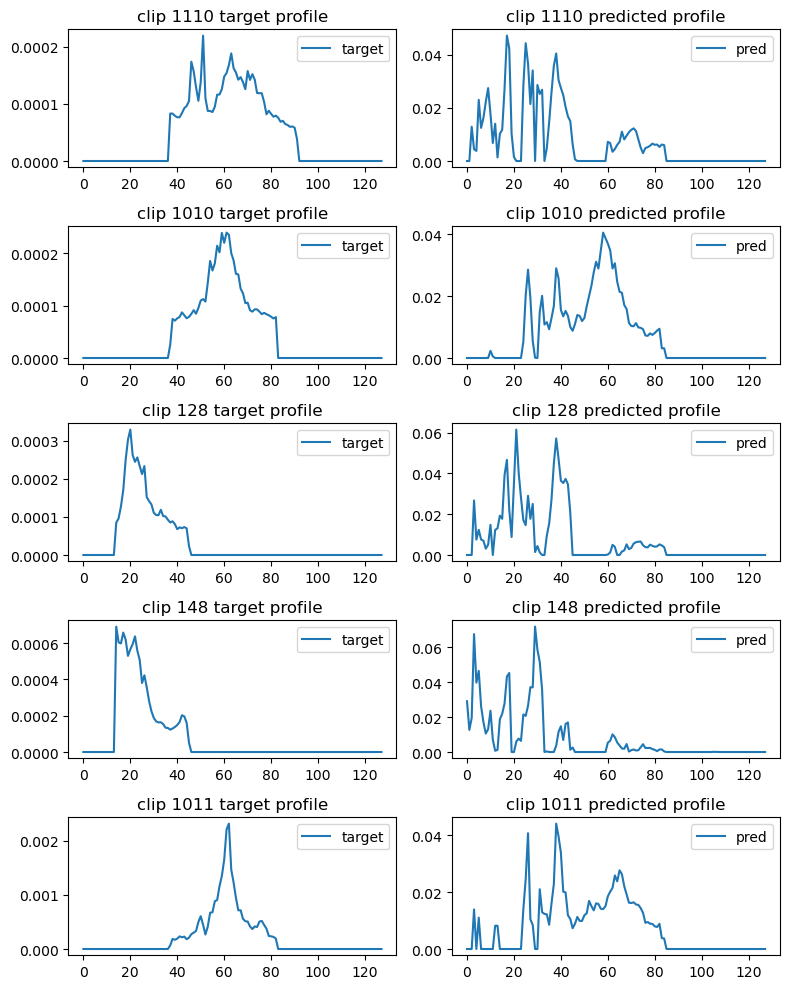

In [3]:
import matplotlib.pyplot as plt

def debug_probe_alignment(Yhat_val, band_masked_spectral_profiles, val_idx, n_examples=5):
    fig, axes = plt.subplots(n_examples, 2, figsize=(8, 2 * n_examples))
    for i, axrow in enumerate(axes):
        j = val_idx[i]
        axrow[0].plot(band_masked_spectral_profiles[j], label="target")
        axrow[0].set_title(f"clip {j} target profile")
        axrow[1].plot(Yhat_val[i], label="pred")
        axrow[1].set_title(f"clip {j} predicted profile")
        for ax in axrow:
            ax.legend()
    plt.tight_layout()
    plt.savefig('./debug_probe_alignment.png')
    plt.show()

debug_probe_alignment(Yhat_val, band_masked_spectral_profiles, val_idx)


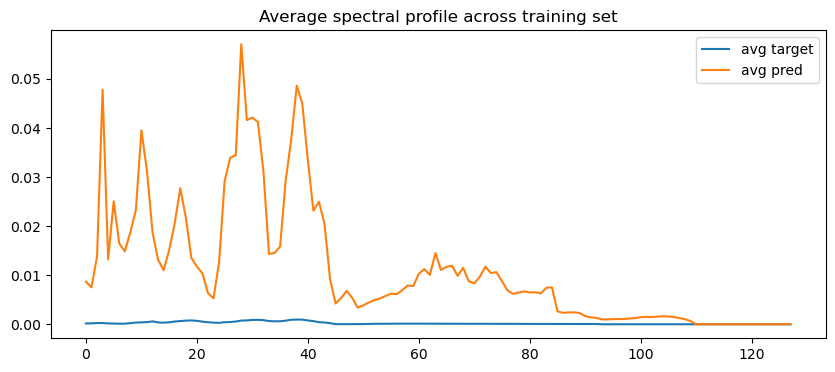

In [4]:
# use the fitted probe returned from poc_band_selective_search
Yhat_train = probe.predict(E[train_idx])

import matplotlib.pyplot as plt

avg_target = band_masked_spectral_profiles[train_idx].mean(axis=0)
avg_pred   = Yhat_train.mean(axis=0)

plt.figure(figsize=(10,4))
plt.plot(avg_target, label="avg target")
plt.plot(avg_pred, label="avg pred")
plt.title("Average spectral profile across training set")
plt.legend()
plt.show()


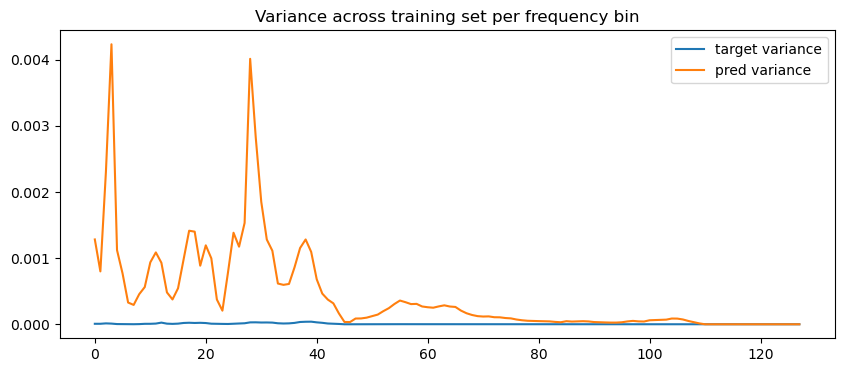

In [5]:
# variance across training set, per frequency bin
var_target = band_masked_spectral_profiles[train_idx].var(axis=0)
var_pred   = Yhat_train.var(axis=0)

plt.figure(figsize=(10,4))
plt.plot(var_target, label="target variance")
plt.plot(var_pred, label="pred variance")
plt.title("Variance across training set per frequency bin")
plt.legend()
plt.show()


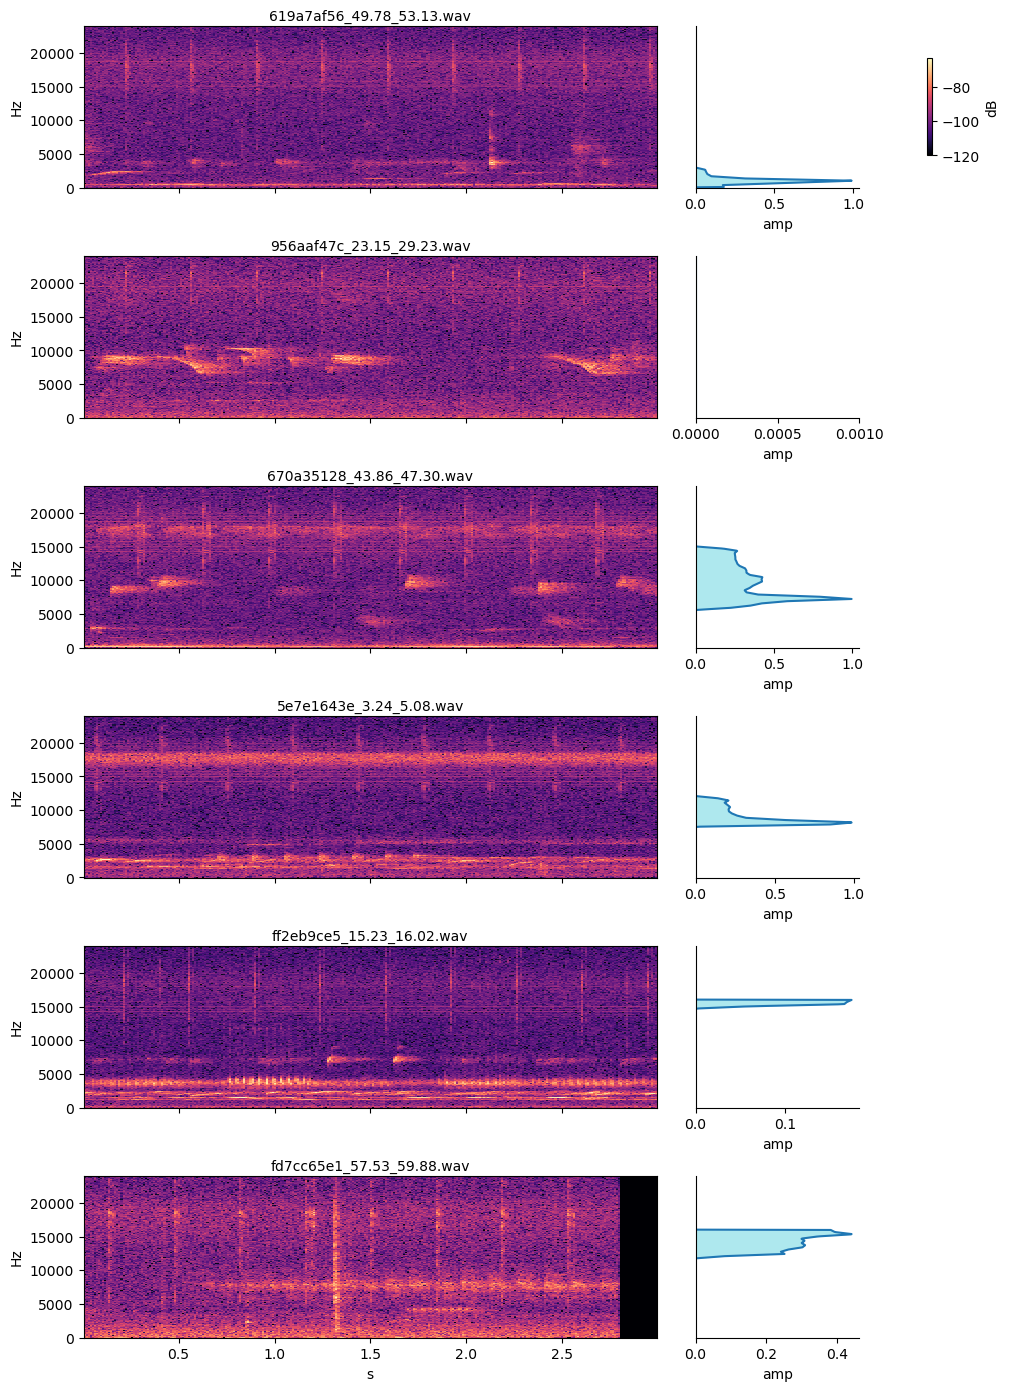

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.interpolate import interp1d
from numpy.random import default_rng

def _load_wav_mono(path):
    # read wav without soundfile/librosa deps
    sr, x = wavfile.read(path)
    # handle int types -> float32 [-1, 1]
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    # mixdown stereo
    if x.ndim == 2:
        x = x.mean(axis=1)
    return sr, x

def _stft_db(x, sr, nperseg=1024, noverlap=512, window='hann', eps=1e-12):
    # guard small clips
    nperseg = min(nperseg, len(x)) if len(x) > 0 else nperseg
    noverlap = min(noverlap, max(0, nperseg // 2))
    f, t, Sxx = spectrogram(x, fs=sr, window=window, nperseg=nperseg, noverlap=noverlap, mode='psd')
    Sxx_db = 10.0 * np.log10(Sxx + eps)
    return f, t, Sxx_db

def _resample_profile_to_freq_axis(profile, band_freqs_hz, target_freqs_hz, nyquist_hz):
    # if band_freqs_hz not provided, assume uniform centers over [0, nyquist]
    if band_freqs_hz is None:
        band_centers = np.linspace(0, nyquist_hz, len(profile))
    else:
        bf = np.asarray(band_freqs_hz).astype(float)
        # if edges are given (len = bins+1), convert to centers
        if bf.size == profile.size + 1:
            band_centers = 0.5 * (bf[:-1] + bf[1:])
        else:
            band_centers = bf
    # clip/infer bounds for interpolation
    band_min = float(np.min(band_centers))
    band_max = float(np.max(band_centers))
    # ensure strictly increasing for interp
    order = np.argsort(band_centers)
    band_centers_sorted = band_centers[order]
    profile_sorted = np.asarray(profile, dtype=float)[order]
    # build interpolator; outside bounds -> 0
    itp = interp1d(
        band_centers_sorted, profile_sorted, kind='linear',
        bounds_error=False, fill_value=0.0, assume_sorted=True
    )
    return itp(target_freqs_hz)

def plot_spec_and_profile_rows(
    filenames,
    band_masked_spectral_profiles,
    band_freqs_hz=None,
    sample_size=8,
    rng_seed=0,
    nperseg=1024,
    noverlap=512,
    cmap='magma',
    normalize='per_sample',  # 'per_sample' | 'global' | 'none'
    figsize=(10, 2.3)
):
    """
    filenames: list/array of wav paths, length N
    band_masked_spectral_profiles: array (N, B) with per-file spectra over B bands
    band_freqs_hz: None (assume uniform over [0, nyquist] per file), or 1D array of band centers,
                   or band edges (len = B+1). if given, it's assumed to be in Hz.
    normalize: how to scale spectra for visualization only
    returns: (fig, sampled_indices)
    """
    filenames = np.asarray(filenames)
    profiles = np.asarray(band_masked_spectral_profiles)
    assert len(filenames) == len(profiles), "filenames and profiles must have same length"

    rng = default_rng(rng_seed)
    k = min(sample_size, len(filenames))
    idx = rng.choice(len(filenames), size=k, replace=False)

    # precompute global max if needed
    if normalize == 'global':
        global_max = np.max(np.clip(profiles, a_min=0, a_max=None)) or 1.0

    fig = plt.figure(figsize=(figsize[0], figsize[1]*k), constrained_layout=True)
    gs = fig.add_gridspec(k, 2, width_ratios=[3.5, 1.0])

    for r, i in enumerate(idx):
        path = filenames[i]
        spec_ax = fig.add_subplot(gs[r, 0])
        prof_ax = fig.add_subplot(gs[r, 1], sharey=spec_ax)

        # load audio and compute spectrogram
        try:
            sr, x = _load_wav_mono(path)
        except Exception as e:
            # fallback: empty plot if read fails
            spec_ax.text(0.5, 0.5, f"read error:\n{e}", ha='center', va='center', fontsize=8)
            spec_ax.set_axis_off()
            prof_ax.set_axis_off()
            continue

        f_hz, t_s, S_db = _stft_db(x, sr, nperseg=nperseg, noverlap=noverlap)
        im = spec_ax.pcolormesh(t_s, f_hz, S_db, shading='auto', cmap=cmap)
        # keep low->high freq bottom->top
        spec_ax.set_ylabel('Hz')
        spec_ax.set_xlabel('s' if r == k-1 else '')
        title = os.path.basename(path)
        spec_ax.set_title(title, fontsize=10, pad=4)

        # build/normalize profile, resampled to spectrogram freq bins
        prof = profiles[i]
        prof = np.nan_to_num(prof, nan=0.0, posinf=0.0, neginf=0.0)

        if normalize == 'per_sample':
            m = np.max(np.abs(prof)) or 1.0
            prof_vis = prof / m
        elif normalize == 'global':
            prof_vis = prof / (global_max or 1.0)
        else:
            prof_vis = prof

        prof_on_f = _resample_profile_to_freq_axis(
            prof_vis, band_freqs_hz, f_hz, nyquist_hz=sr/2.0
        )

        # plot vertical profile aligned to the same y (frequency) axis
        prof_ax.fill_betweenx(f_hz, 0, prof_on_f, color='tab:cyan', alpha=0.35, linewidth=0)
        prof_ax.plot(prof_on_f, f_hz, color='tab:blue', lw=1.5)

        # tidy the profile axis
        prof_ax.set_xlim(0, max(1.05*np.max(prof_on_f), 1e-3))
        prof_ax.set_xlabel('amp')
        prof_ax.yaxis.set_visible(False)
        for spine in ['top', 'right']:
            prof_ax.spines[spine].set_visible(False)

        # tidy spectrogram axis
        if r != k-1:
            spec_ax.set_xticklabels([])

    # add a single colorbar for the last image
    cbar = fig.colorbar(im, ax=[fig.axes[0], fig.axes[1]], shrink=0.6, location='right')
    cbar.set_label('dB')

    return fig, idx

fig, idx = plot_spec_and_profile_rows(
    [clips_dir + i for i in filenames], 
    band_masked_spectral_profiles, 
    band_freqs_hz=np.linspace(50, 16000, 50), 
    sample_size=6
)
plt.show()
